In [3]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pdg.api
import pandas as pd
from scipy.interpolate import interp1d
from scipy.spatial import cKDTree

In [7]:
api = pdg.connect(pedantic=True)

file = uproot.open("/lstr/sahara/dune/arahe/CP2Course/CP2GroupProject/TylerStuff/CCode/Analysis/gen1_mu_cc_1000_events_new.root")

muonplot=pd.read_csv("/lstr/sahara/dune/z2039949/muon.csv",header=None, usecols=[0,1])
protonplot=pd.read_csv("/lstr/sahara/dune/z2039949/proton.csv",header=None, usecols=[0,1])
pionplot=pd.read_csv("/lstr/sahara/dune/z2039949/pion.csv",header=None, usecols=[0,1])


In [8]:
gen1tree = file["ana/gen1;1"]
anatree=file["ana;1"]

# anatree.keys()
gen1tree.keys()
Reco = gen1tree.arrays(['eventID',
                      'recoNParticles',
                      'reco',
                      'recoGeneration',
                      'recoTrackLength',
                      'recoTrackScore',
                      'recodEdx',
                      'recoResidualRange'])
Sim = gen1tree.arrays(['simNParticles',
                     'sim',
                     'simGeneration',
                     'simPdgCode',
                     'simEnergy',
                     'simID'])


gen1sim = ak.zip({
    "N" : Sim['simNParticles'],
    "sim" : Sim["sim"],
    "gen" : Sim['simGeneration'],
    "pdg" : Sim["simPdgCode"],
    "energy" : Sim['simEnergy'],
    "ID" : Sim["simID"]
})

rec = ak.zip({
    "eventID" : Reco['eventID'],
    "recoNParticles" : Reco['recoNParticles'],
    "recoGeneration" : Reco['recoGeneration'],
    "recoTrackLength" : Reco['recoTrackLength'],
    "recoTrackScore" : Reco['recoTrackScore'],
    "recodEdx" : Reco['recodEdx'],
    "recoResidualRange" : Reco['recoResidualRange']
})

In [10]:
energy = ak.flatten(ak.Array(rec.recodEdx), axis = None)
track_length = ak.flatten(ak.Array(rec.recoResidualRange), axis = None)

In [11]:
x = np.asarray(track_length, dtype = 'float')
y = np.asarray(energy, dtype = 'float')
mask = (x > 0) & (y > 0)
x, y = x[mask], y[mask]

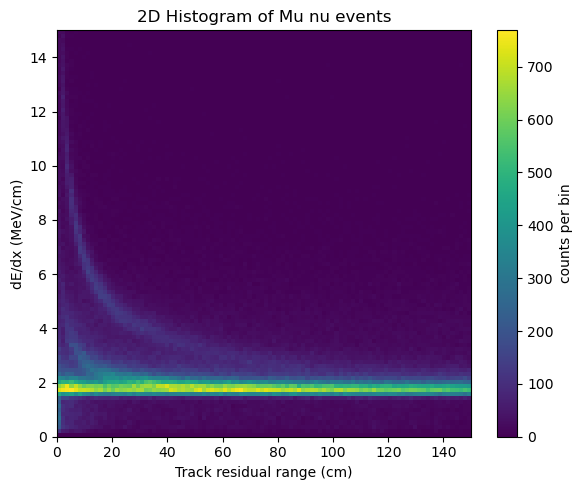

In [12]:
plt.figure(figsize=(6,5))
hb = plt.hist2d(
    x, y,
    bins=[100, 100],
    range=[
        [0, 150],
        [0, 15]
    ],
    cmap='viridis'
)
plt.colorbar(hb[3], label='counts per bin')
plt.xlabel("Track residual range (cm)")
plt.ylabel("dE/dx (MeV/cm)")
plt.title("2D Histogram of Mu nu events")
plt.tight_layout()
plt.show()

Lauren's silly little way of doing it:
- Make cuts based off of three different regions of protons (#1- de/dx > 7.5 & range < 10cm, #2- de/dx > 4 & 11 cm < range < 20 cm, #3- de/dx > 3.5 & range > 21 cm)
- 

In [67]:
def protoncut(reco):
    mask_fast = (reco.recodEdx >= 7.5) & (reco.recoResidualRange< 10) & (protons_maybe.recoTrackScore >= 0.70)
    mask_chill = (reco.recodEdx >= 4) & ( 10 < reco.recoResidualRange)& (reco.recoResidualRange < 20) & (protons_maybe.recoTrackScore >= 0.70)
    mask_slow = (reco.recodEdx > 3.7) & (21 < reco.recoResidualRange) & (protons_maybe.recoTrackScore >= 0.70)
    protons_maybe = reco[(mask_fast) | (mask_slow)| (mask_chill)]
    
    return protons_maybe

In [62]:
protons_maybe = protoncut(rec)
n_hits = ak.num(protons_maybe.recoResidualRange, axis=2)
#good = (protons_maybe.recoTrackScore >= 0.70)
protons1 = protons_maybe[good]

In [68]:
mask_1 = ak.num(protons_maybe, axis =2) > 0
protons2 = protons_maybe[mask_1]
print(len(protons2.recoResidualRange))

935


In [69]:
mask_3 = ak.num(protons2, axis =1) >0 
protons3 = protons2[mask_3]
print(len(protons3.recoResidualRange))

896


In [70]:
track_1 = protons3.recoResidualRange[..., 1:] - protons3.recoResidualRange[..., :-1]
avg_dedx = 0.5 * (protons3.recodEdx[..., 1:] - protons3.recodEdx[..., :-1])
energy = track_1 * avg_dedx
total_energy_1 = ak.sum(energy, axis =2)
total = ak.ravel(total_energy_1)
abs_total = np.abs(total)

(array([2123.,  362.,  181.,  110.,   93.,   73.,   39.,   37.,   30.,
          27.,   18.,   23.,   12.,   11.,   17.,   10.,    8.,   10.,
           6.,    6.]),
 array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
         450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
         900.,  950., 1000.]),
 <BarContainer object of 20 artists>)

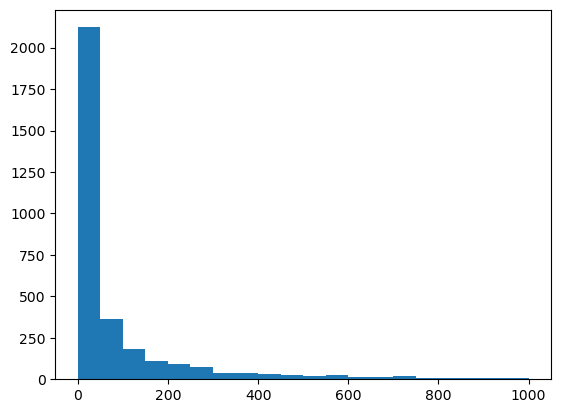

In [71]:
plt.hist(abs_total, bins = 20, range = (0, 1000))

- My way- doesn't really work? The calculation works (look at later stuff) but for whatever reason the way that I am using the arrays, it is not correct. But if you do the calculation with Layne's array usage, it does work. Whatever. 
- Layne's way of things: 

In [51]:
maxvalue=100
muondedx=muonplot[1]
muonrange=muonplot[0]
protondedx=protonplot[1]
protonrange=protonplot[0]
piondedx=pionplot[1]
pionrange=pionplot[0]

interp_func = interp1d(muonrange, muondedx, kind='linear')  
new_muonrange = np.linspace(muonrange.min(), muonrange.max(), 500)

new_muondedx = interp_func(new_muonrange)


interp_func = interp1d(protonrange, protondedx, kind='linear')  
new_protonrange = np.linspace(protonrange.min(), protonrange.max(), 500)

new_protondedx = interp_func(new_protonrange)

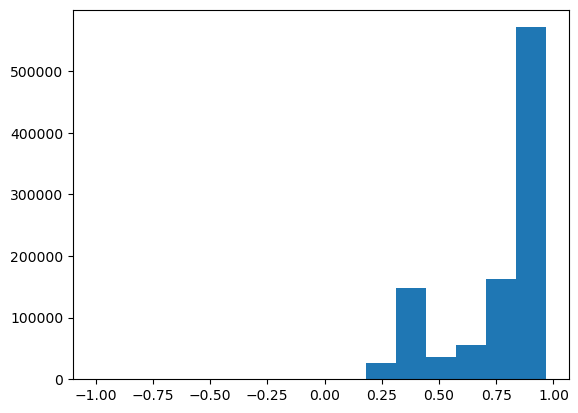

In [75]:
simprotons=(ak.ravel(gen1sim.pdg)==2212)
simmuons=ak.ravel(gen1sim.pdg==(13 or -13))

energy=ak.ravel(gen1sim.energy)

plt.hist(ak.ravel(rec.recoTrackScore),bins=15)

threshold =0.50

maxvalue=1e6
trackscore=0.7
cut = rec.recoTrackScore > trackscore

In [76]:
# Apply mask while preserving structure
filtered_dedx = ak.flatten(rec.recodEdx[cut],axis=-2)
filtered_range = ak.flatten(rec.recoResidualRange[cut],axis=-2)
filtered_length = ak.flatten(rec.recoTrackLength[cut],axis=-2)

# Zip into 2D-like records instead of NumPy stack
filtered_points = ak.zip({"x": filtered_range, "y": filtered_dedx})

# Convert new_muon and new_proton points into flat 2D NumPy arrays for KDTree
newmuon_points = np.stack((new_muonrange, new_muondedx), axis=1)
newproton_points = np.stack((new_protonrange, new_protondedx), axis=1)

# Build KDTree on flattened reference points
muontree = cKDTree(newmuon_points)
protontree = cKDTree(newproton_points)



flat_range = ak.to_numpy(ak.ravel(filtered_range))
flat_dedx = ak.to_numpy(ak.ravel(filtered_dedx))
flat_points = np.column_stack((flat_range, flat_dedx))


# Query KDTree for distances
muondistances, _ = muontree.query(flat_points)
protondistances, _ = protontree.query(flat_points)

# Rebuild the nested structure of mask using ak.unflatten
counts = ak.num(filtered_range)  # Get the counts per sublist

print(ak.sum(counts))

muon_cut = ak.unflatten(muondistances < threshold, counts)
proton_cut = ak.unflatten(protondistances < threshold, counts)

# # Apply structured mask to keep the nested structure
filteredmuon_range = filtered_range[muon_cut]
filteredmuon_dedx = filtered_dedx[muon_cut]
filteredmuon_tracklength = filtered_length[muon_cut]

filteredproton_range = filtered_range[proton_cut]
filteredproton_dedx = filtered_dedx[proton_cut]
filteredproton_tracklength = filtered_length[proton_cut]


739141


In [79]:
#Layne's array format but with Lauren's Math 
distance = filteredproton_range[..., 1:] - filteredproton_range[..., :-1]
energy = filteredproton_dedx[..., :-1] * distance
non_zero_mask = ak.num(energy) > 0 
non_zero_energy = energy[non_zero_mask]
total_energy_lauren_1 = ak.sum(non_zero_energy,axis=1)
#total_energy_lauren_1


In [92]:
#What if we shifted my math, right now doing: [n(n-1) * n], what if we did [n(n-1} * {n-1}]
energy_2 =  filteredproton_dedx[..., 1:] * distance
non_zero_2 = ak.num(energy_2) > 0
non_zero_e_2 = energy_2[non_zero_2]
total_energy_lauren_2 = ak.sum(non_zero_e_2, axis =1)
#total_energy_lauren_2

In [136]:
# One more idea- instaed of taking the difference and multiplying each input, take the final input of residual range
# and multiply it by the summed energy
last_range = filteredproton_range[..., -1:]
sum_energy = ak.mean(filteredproton_dedx, axis = 1)
#That is a gross approximation, will result in shittier answer
energy_3 = last_range * sum_energy
kill_empty = ak.num(energy_3) > 0
total_energy_lauren_3 = ak.ravel(energy_3[kill_empty])
print(total_energy_lauren_3)

[271, 314, 141, 286, 367, 302, 314, 245, ..., 324, 299, 188, 319, 333, 276, 293]


In [139]:
totalE=ak.ArrayBuilder()
muonE=ak.ArrayBuilder()
protonE=ak.ArrayBuilder()
# print(filtered_range[1][0])
Energy=0

muoncut=[]
protoncut=[]

for p in range(len(filtered_range)):
    #totalE.append(ak.sum((filtered_range[p][1:]-filtered_range[p][:-1])*0.5*(filtered_dedx[p][1:]+filtered_dedx[p][:-1]), axis =0))
    x = (filtered_range[p][1:]-filtered_range[p][:-1])
    y = x * 0.5 * (filtered_dedx[p][1:]+filtered_dedx[p][:-1])
    soup = ak.sum(y)
    totalE.append(soup)
    
    
totalEsnap=totalE.snapshot()



for n in range(len(filteredmuon_range)):
    muonE.append(ak.sum((filteredmuon_range[n][1:]-filteredmuon_range[n][:-1])*0.5*(filteredmuon_dedx[n][1:]+filteredmuon_dedx[n][:-1])))
    
    
muonEsnap=muonE.snapshot()



for q in range(len(filteredproton_range)):
    protonE.append(ak.sum((filteredproton_range[q][1:]-filteredproton_range[q][:-1])*0.5*(filteredproton_dedx[q][1:]+filteredproton_dedx[q][:-1])))
    #x = (filteredproton_range[q][1:]-filteredproton_range[q][:-1])
    #y = x * 0.5 * (filteredproton_dedx[q][1:]+filteredproton_dedx[q][:-1])
    #bing = ak.sum(y)
    #protonE.append(bing)
    
protonEsnap=protonE.snapshot()




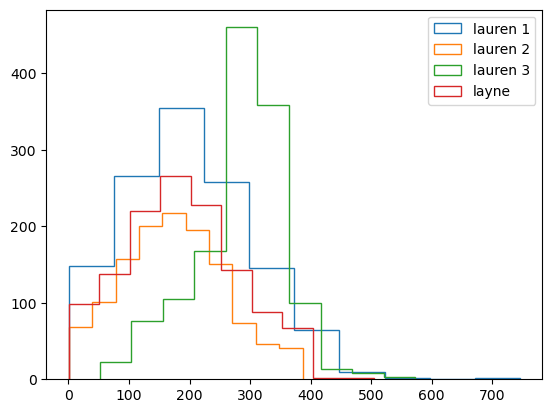

In [137]:
#Compare the two methods
plt.hist(total_energy_lauren_1, histtype = 'step', label = 'lauren 1')
plt.hist(total_energy_lauren_2, histtype = 'step', label = 'lauren 2')
plt.hist(total_energy_lauren_3, histtype = 'step', label = 'lauren 3')
plt.hist(protonEsnap[protonEsnap>0], histtype = 'step', label = 'layne')
plt.legend()
plt.show()


lol proved that trapezoidal sums work, neato mosquito

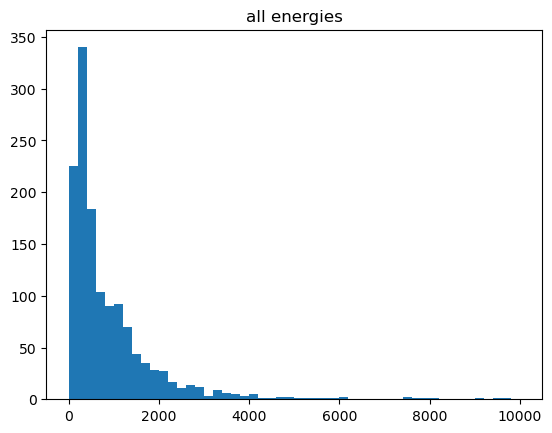

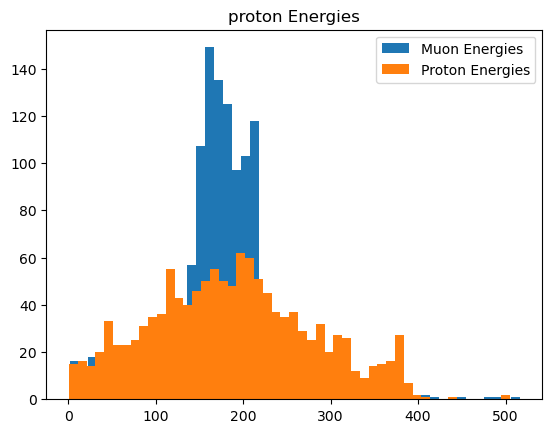

In [142]:
plt.hist(totalEsnap[totalEsnap>0],bins=50, range = [0, 10000])
plt.title("all energies")
plt.show()


plt.hist(muonEsnap[(muonEsnap>0)],bins=50, label = 'Muon Energies')
plt.hist(protonEsnap[(protonEsnap>0)],bins=50, label = 'Proton Energies')
plt.legend()
plt.title("proton Energies")
plt.show()


#print(protonEsnap)
#print((sum(protonEsnap>0)))
#print(sum(muonEsnap>0))


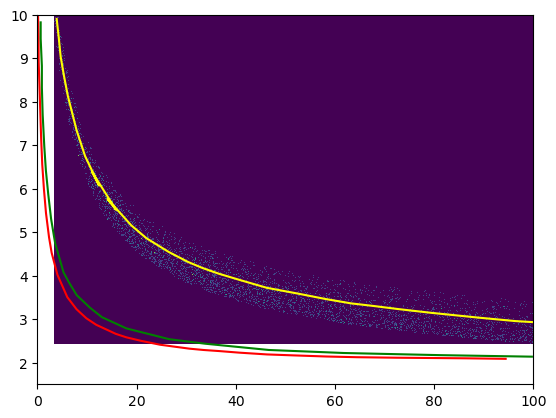

In [58]:
plt.hist2d(ak.to_numpy(ak.flatten(filteredproton_range)),ak.to_numpy(ak.flatten(filteredproton_dedx)),bins=1000)
plt.ylim(1.5,10)
plt.xlim(0,100)
plt.plot(muonrange,muondedx,color='red')
plt.plot(protonrange,protondedx,color='yellow')
plt.plot(pionrange,piondedx,color='green')



cmap="virdis"
plt.show()



15.256939
[1.27, 1.14, 1.05, 1.14, 0.97, 1.19, 1.08, 1.08, 1.08, 1.05]


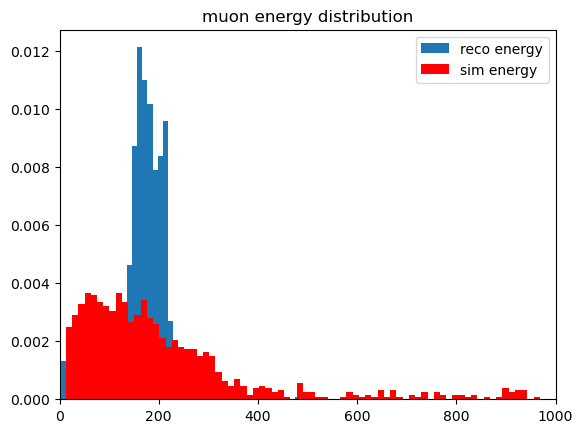

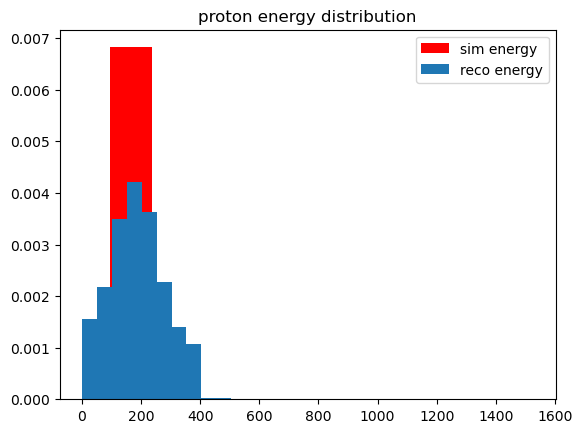

(array([ 19710.,  19791.,  34704.,  35276.,  40100.,  67295., 126277.,
        183371., 168177.,  19358.]),
 array([0.70004505, 0.72695428, 0.75386345, 0.78077269, 0.80768186,
        0.83459109, 0.86150026, 0.8884095 , 0.91531873, 0.9422279 ,
        0.96913713]),
 <BarContainer object of 10 artists>)

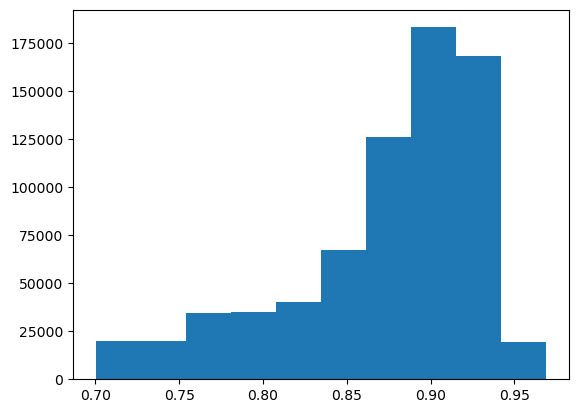

In [59]:
print(max(energy[simprotons]))
print(energy[simprotons][:10])

binsize=100



plt.hist(muonEsnap[muonEsnap>0],label="reco energy",bins=50,density=True)
plt.hist(energy[simmuons]*100, color='red',label="sim energy",bins=500,density=True)
plt.xlim(0,1000)
plt.title("muon energy distribution")
plt.legend()
plt.show()



plt.hist(energy[simprotons]*100, color='red',label='sim energy', density=True)
plt.hist(protonEsnap[protonEsnap>0], label='reco energy', density=True)
# plt.xlim(0,400)
plt.title("proton energy distribution")
plt.legend()

plt.show()


# %%

track=ak.flatten(rec.recoTrackScore,axis=1)


protontrack=track[protonEsnap>0]
plt.hist(ak.ravel(protontrack))